In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from fastsklearnfeature.dfs.SimulatedAnnealing import SimulatedAnnealing
from fastsklearnfeature.dfs.TPEChi2 import TPEChi2
from fastsklearnfeature.dfs.SFS import SFS
from fastsklearnfeature.dfs.DataLoader import DataLoader
from fastsklearnfeature.dfs.QueryOptimizer import QueryOptimizer
from fastsklearnfeature.dfs.ForwardSelection import ForwardSelection
from fastsklearnfeature.dfs.TPE_NR import TPE_NR
import numpy as np
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True) 

# Notebook for Declarative Feature Selection (DFS)

We describe how to interactively design ML scenarios that DFS can solve for you.

The first step is loading the data. You need to define a training, a validation and a test set. Here, we use the Adult dataset where we have to classify whether the yearly income of a person exceeds $50K.

In [2]:
dl = DataLoader()
X_train, X_validation, X_test, y_train, y_validation, y_test, feature_names, sensitive_ids = dl.get_data(dataset='Adult')

Now, you can use potentially any feature selection strategy to satisfy your ML application constraints. Here, our application constraint is that we need a minimum accuracy of 80% and we choose to apply the well-known sequential forward selection strategy for search.

In [3]:
sfs = ForwardSelection(floating=False)
sfs.query(X_train,
			X_validation,
			X_test,
			y_train,
			y_validation,
			y_test,
			min_accuracy=0.80,
			max_search_time=120,
			feature_names=feature_names
			)

function took longer than 120 seconds


array([], dtype=float64)

As you see, this feature selection strategy does not find a solution for the specified constraint within in the specified maximum search time.

So, instead of manually choosing the feature selection strategy, we trained a meta-learning-driven query optimizer based on 3000 different ML scenarios across 19 datasets.
This optimizer will automatically choose the feature selection strategy that it estimates to have the highest chance of success:

In [4]:
optimizer = QueryOptimizer()
optimizer.query(X_train,
			X_validation,
			X_test,
			y_train,
			y_validation,
			y_test,
			min_accuracy=0.80,
			max_search_time=120,
			feature_names=feature_names
			)

Within 0.829876184463501 seconds, the Optimizer chose to run TPE(NR)
100%|██████████| 1/1 [00:50<00:00, 50.01s/trial, best loss: 0.0]


array(['workclass_Local-gov', 'workclass_State-gov', 'workclass_missing',
       'education_10th', 'education_11th', 'education_12th',
       'education_1st-4th', 'education_5th-6th', 'education_HS-grad',
       'education_Preschool', 'education_Prof-school',
       'education_Some-college', 'marital-status_Divorced',
       'marital-status_Married-civ-spouse',
       'marital-status_Married-spouse-absent',
       'marital-status_Never-married', 'marital-status_Separated',
       'marital-status_Widowed', 'occupation_Adm-clerical',
       'occupation_Armed-Forces', 'occupation_Craft-repair',
       'occupation_Other-service', 'occupation_Protective-serv',
       'occupation_Sales', 'occupation_Tech-support',
       'occupation_missing', 'relationship_Husband',
       'relationship_Other-relative', 'relationship_Unmarried',
       'race_Asian-Pac-Islander', 'race_Black', 'race_White',
       'native-country_China', 'native-country_Columbia',
       'native-country_Ecuador', 'native-coun

As we see, the optimizer chooses the feature selection strategy TPE(NR) that quickly yields a set of features that satisfy all specified constraints. The optimizer estimates for each strategy the likelihood of success for the specified ML scenario, as shown in the next cell:

Within 0.6136219501495361 seconds, the Optimizer chose to run TPE(NR)


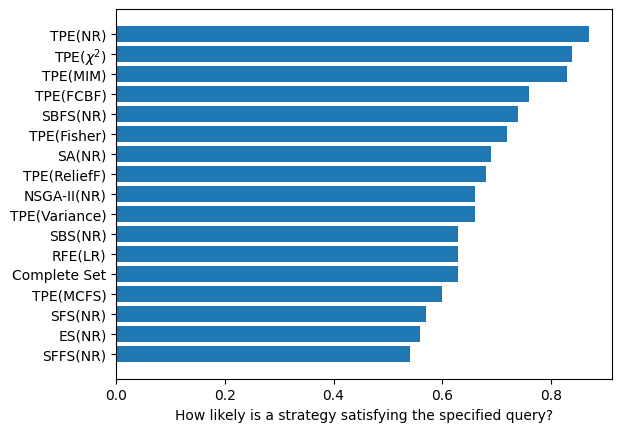

In [19]:
optimizer.get_plan(X_train,
			X_validation,
			X_test,
			y_train,
			y_validation,
			y_test,
			min_accuracy=0.80,
			max_search_time=120,
			feature_names=feature_names
			)

Here, we see that indeed the sequential forward selection strategy (SFS) was a poor choice for this ML scenario. If you are more interested why the optimizer chose TPE(NR), we can use the explainability library ELI5 to explain the prediction: 

In [6]:
optimizer.explain_plan_choice()

Here, we see that the optimizer favored TPE(NR) because of there was no privacy or fairness constraint specified and the classification model was not Naive Bayes.

However, we are not only interested in accuracy, we are also looking for a fair feature representation. Therefore, we set the minimum fairness to 85%. Furthermore, we have specify the binary features that contain the sensitive attribute that should be fair (sensitive_ids). In our case, the sensitive attribute is gender.

In [7]:
optimizer.query(X_train,
			X_validation,
			X_test,
			y_train,
			y_validation,
			y_test,
			min_accuracy=0.80,
			sensitive_ids=sensitive_ids,
			min_fairness=0.85,
			max_search_time=120,
			feature_names=feature_names
			)

Within 0.7893869876861572 seconds, the Optimizer chose to run TPE(MIM)
100%|██████████| 1/1 [00:40<00:00, 40.08s/trial, best loss: 0.0014120300534812928]
function took longer than 120 seconds


array([], dtype=float64)

Unfortunately, the strategy that the optimizer proposed did not yield a solution. Therefore, we can ask the optimizer how to adjust our constraints in order to improve the likelihood of success:

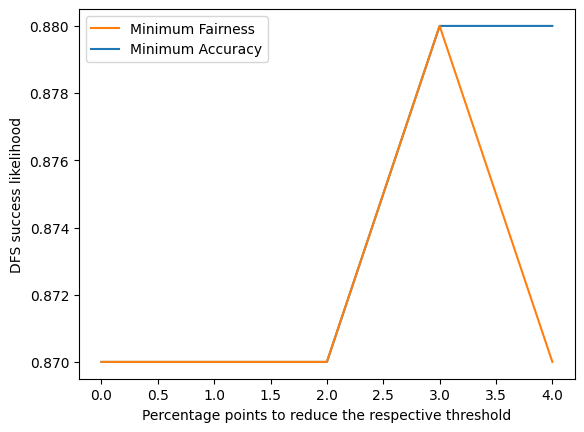

In [8]:
optimizer.how_to_improve_the_success_likelihood()

Here, we see how much the likelihood of success increases if we either decrease the fairness or accuracy constraint by 1, 2, ... 5 percentage points. We see that reducing fairness inceases the likelihood signficantly. Therefore, we reduce fairness by 5% to 80% and rerun:

In [9]:
optimizer.query(X_train,
			X_validation,
			X_test,
			y_train,
			y_validation,
			y_test,
			min_accuracy=0.80,
			sensitive_ids=sensitive_ids,
			min_fairness=0.80,
			max_search_time=120,
			feature_names=feature_names
			)

Within 0.5304179191589355 seconds, the Optimizer chose to run TPE(NR)
100%|██████████| 1/1 [00:34<00:00, 34.22s/trial, best loss: 0.0]


array(['workclass_Never-worked', 'workclass_Self-emp-inc',
       'workclass_State-gov', 'education_7th-8th', 'education_Assoc-acdm',
       'education_Doctorate', 'education_HS-grad', 'education_Preschool',
       'education_Some-college', 'marital-status_Divorced',
       'marital-status_Married-spouse-absent',
       'marital-status_Never-married', 'marital-status_Separated',
       'occupation_Adm-clerical', 'occupation_Craft-repair',
       'occupation_Exec-managerial', 'occupation_Farming-fishing',
       'occupation_Machine-op-inspct', 'occupation_Other-service',
       'occupation_Priv-house-serv', 'occupation_Prof-specialty',
       'occupation_Tech-support', 'occupation_missing',
       'relationship_Not-in-family', 'relationship_Own-child',
       'relationship_Wife', 'race_Amer-Indian-Eskimo',
       'race_Asian-Pac-Islander', 'race_White', 'sex_Male',
       'native-country_Cambodia', 'native-country_Columbia',
       'native-country_Cuba', 'native-country_Germany',
      

Finally, we can show the resulting scores across metrics for the test data:

In [10]:
fig = optimizer.get_test_radar_chart()
iplot(fig) 

As you can see the representation satisfies all specified constraints of accuracy and fairness, but has a high number of features (high complixity = low simplicity) and a low safety against adversarial examples. 

Another approach is that you are happy with the F1 score of 80% but you want to get a classifier that is as fair as possible. That means, we specify fairness as utility subject to the accuracy constraint. Note that we mark a constraint as utility by setting it to infinity:

In [16]:
optimizer.query(X_train,
			X_validation,
			X_test,
			y_train,
			y_validation,
			y_test,
			min_accuracy=0.80,
			max_search_time=600,
            sensitive_ids=sensitive_ids,
			min_fairness=np.inf, #here fairness is the utility
			feature_names=feature_names
			)

Within 1.1380717754364014 seconds, the Optimizer chose to run TPE(MIM)
100%|██████████| 5/5 [00:59<00:00, 59.01s/trial, best loss: -0.8151897985695244]
function took longer than 600 seconds


array([], dtype=float64)

In [17]:
fig = optimizer.get_test_radar_chart()
iplot(fig) 

This time, DFS was abe to find features that both satisfy the accuracy constraint and reach a little bit higher fairness.

In the following figure, you can see how the objective is minimized over time:

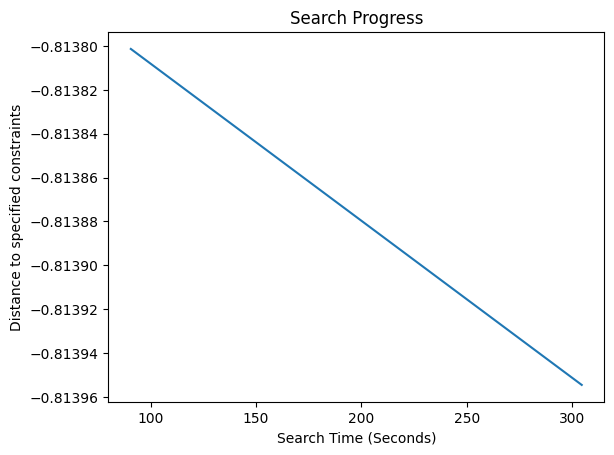

In [13]:
optimizer.get_progress()

Now, it's your turn to play around a bit more with declarative feature selection.